# Normalizing Features with Graph Convolutional Networks

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [20 lines of output]
  Traceback (most recent call last):
    File "C:\Users\thitr\Desktop\monMXH\M-n-m-ng-x-h-i\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\thitr\Desktop\monMXH\M-n-m-ng-x-h-i\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\thitr\Desktop\monMXH\M-n-m-ng-x-h-i\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
      return hook(config_settings)
             ^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\thitr\AppData\Local\Temp\pip-build-env-1kzcyxkv\overlay\Lib\site-packages\setuptools\build_meta.py", line

In [2]:
import numpy as np
np.random.seed(0)
# Khởi tạo ma trận chéo D
D = np.array([
    [3, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 2]
])

In [3]:
# Tính nghịch đảo của ma trận D
np.linalg.inv(D)

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

In [4]:
# Tính nghịch đảo của ma trận (D + I), với I là ma trận đơn vị
np.linalg.inv(D + np.identity(4))

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

In [5]:
# Khởi tạo ma trận A
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])
# Tính tích của ma trận (D + I)^-1 và A
print(np.linalg.inv(D + np.identity(4)) @ A)
print()

# Tính tích của ma trận A và (D + I)^-1
print(A @ np.linalg.inv(D + np.identity(4)))

[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]

[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


<BarContainer object of 37 artists>

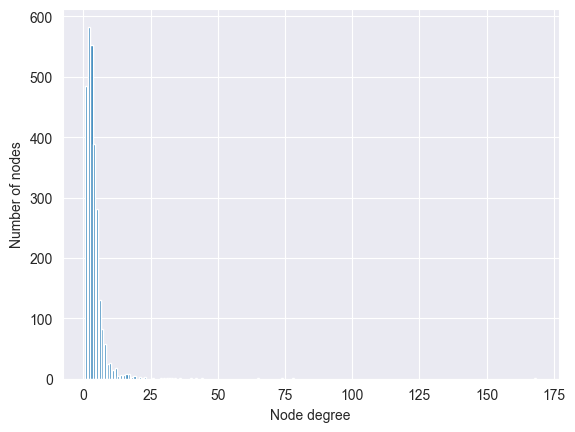

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

# Import dataset from PyTorch Geometric # Tải bộ dữ liệu Planetoid
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Get list of degrees for each node # Tính toán bậc của các đỉnh
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree # Đếm số lượng đỉnh cho mỗi bậc
numbers = Counter(degrees)

# Bar plot # Vẽ biểu đồ
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

<BarContainer object of 233 artists>

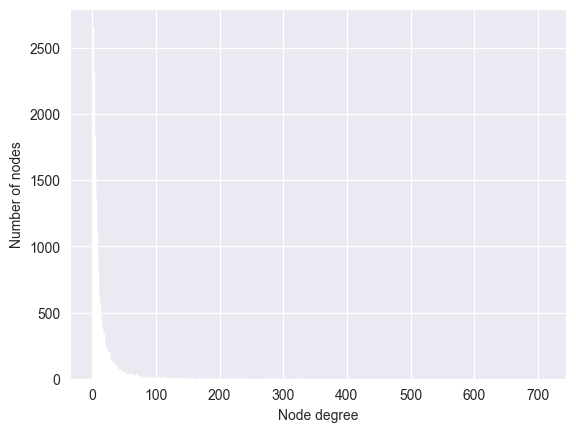

In [7]:
from torch_geometric.datasets import FacebookPagePage

# Import dữ liệu từ thư viện PyTorch Geometric
dataset = FacebookPagePage(root=".")
data = dataset[0]

# Tạo các mask cho việc phân chia dữ liệu
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Lấy danh sách bậc (degree) của từng nút trong đồ thị
degrees = degree(data.edge_index[0]).numpy()

# Đếm số lượng nút ứng với từng bậc (degree)
numbers = Counter(degrees)

# Vẽ biểu đồ cột
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [8]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Tải bộ dữ liệu từ Planetoid
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Hàm tính độ chính xác
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

# Lớp GCN
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Khởi tạo mô hình Vanilla GNN 
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# huấn luyện mô hình
gcn.fit(data, epochs=100)

# Kiểm thử
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.932 | Train Acc: 15.71% | Val Loss: 1.94 | Val Acc: 15.20%
Epoch  20 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.80%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.00%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 76.40%

GCN test accuracy: 79.70%



In [9]:
# Tải tập dữ liệu Facebook Page-Page từ thư viện PyTorch Geometric
dataset = FacebookPagePage(root=".")
data = dataset[0]

# Tạo các mask cho tập huấn luyện, kiểm tra và thử nghiệm
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Huấn luyện mô hình GCN (Graph Convolutional Network)
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.463 | Train Acc: 20.72% | Val Loss: 1.45 | Val Acc: 20.71%
Epoch  20 | Train Loss: 0.443 | Train Acc: 84.64% | Val Loss: 0.43 | Val Acc: 85.29%
Epoch  40 | Train Loss: 0.323 | Train Acc: 89.59% | Val Loss: 0.31 | Val Acc: 90.20%
Epoch  60 | Train Loss: 0.278 | Train Acc: 91.36% | Val Loss: 0.27 | Val Acc: 91.55%
Epoch  80 | Train Loss: 0.254 | Train Acc: 92.28% | Val Loss: 0.26 | Val Acc: 92.75%
Epoch 100 | Train Loss: 0.238 | Train Acc: 92.83% | Val Loss: 0.25 | Val Acc: 92.75%

GCN test accuracy: 91.70%



In [10]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

# Tải dữ liệu Wikipedia Network với tên 'chameleon' và áp dụng transform
# Sử dụng RandomNodeSplit để tạo ngẫu nhiên các tập huấn luyện, kiểm tra và thử nghiệm
dataset = WikipediaNetwork(root=".", name="chameleon", transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0] # Lấy đồ thị đầu tiên từ tập dữ liệu

# In thông tin về tập dữ liệu
print(f'Dataset: {dataset}')  # In ra tập dữ liệu đang sử dụng
print('-------------------')
print(f'Number of graphs: {len(dataset)}')  # Số lượng đồ thị trong tập dữ liệu
print(f'Number of nodes: {data.x.shape[0]}')  # Số lượng nút (node) trong đồ thị
print(f'Number of unique features: {dataset.num_features}')  # Số lượng đặc trưng (features) duy nhất của đồ thị
print(f'Number of classes: {dataset.num_classes}')  # Số lượng lớp (classes) trong tập dữ liệu

# In thông tin về đồ thị
print(f'\nGraph:')  # In ra thông tin về đồ thị
print('------')
print(f'Edges are directed: {data.is_directed()}')  # Kiểm tra xem các cạnh có hướng hay không
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')  # Kiểm tra xem đồ thị có nút bị cô lập hay không
print(f'Graph has loops: {data.has_self_loops()}')  # Kiểm tra xem đồ thị có vòng lặp (self-loops) hay không

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


In [11]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# Tải file zip từ URL
url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [12]:
import pandas as pd

# Đọc file CSV với thông tin mục tiêu từ thư mục đã giải nén
df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target'])
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

<BarContainer object of 63 artists>

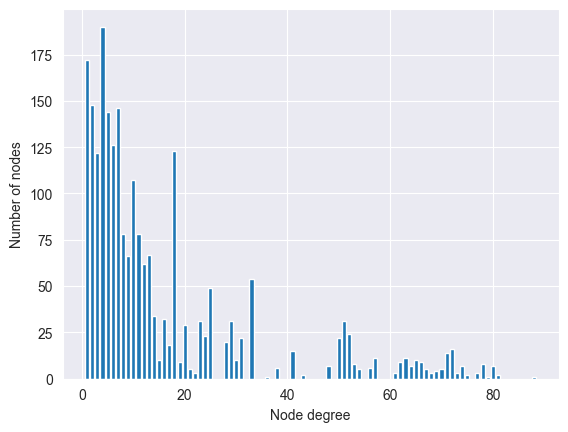

In [13]:
from torch_geometric.utils import degree
from collections import Counter

# Lấy danh sách bậc (degree) của từng nút trong đồ thị
degrees = degree(data.edge_index[0]).numpy()

# Đếm số lượng nút ứng với từng bậc
numbers = Counter(degrees)

# Vẽ biểu đồ cột
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

C:\Users\thitr\AppData\Local\Temp\ipykernel_17184\2792940269.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(df['target'], fit=norm)


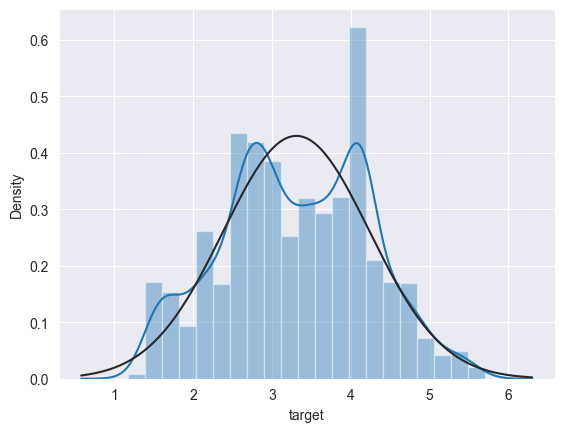

In [14]:
import seaborn as sns
from scipy.stats import norm

# Gán cột 'target' trong DataFrame bằng các giá trị đã tính toán
df['target'] = values

# Vẽ biểu đồ phân phối với seaborn
fig = sns.distplot(df['target'], fit=norm)

In [15]:
# Định nghĩa lớp GCN

class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

    def fit(self, data, epochs): 
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.02,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())

# Khởi tạo mô hình GCN 
gcn = GCN(dataset.num_features, 128, 1)
print(gcn) 

# huấn luyện
gcn.fit(data, epochs=200)

# Kiểm thử mô hình với bộ dữ liệu test
loss = gcn.test(data)
print(f'\nGCN test loss: {loss:.5f}\n')

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 12.81936 | Val Loss: 13.00659
Epoch  20 | Train Loss: 11.71822 | Val Loss: 11.76676
Epoch  40 | Train Loss: 10.29417 | Val Loss: 10.34435
Epoch  60 | Train Loss: 8.67988 | Val Loss: 8.72097
Epoch  80 | Train Loss: 4.03177 | Val Loss: 4.00313
Epoch 100 | Train Loss: 1.94211 | Val Loss: 2.00301
Epoch 120 | Train Loss: 0.97431 | Val Loss: 1.10883
Epoch 140 | Train Loss: 0.73376 | Val Loss: 0.89986
Epoch 160 | Train Loss: 0.58745 | Val Loss: 0.79570
Epoch 180 | Train Loss: 0.52040 | Val Loss: 0.79910
Epoch 200 | Train Loss: 0.50753 | Val Loss: 0.69298

GCN test loss: 0.72017



In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Dự đoán giá trị cho dữ liệu test
out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()

# Tính các metric
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

# In kết quả các metric
print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

MSE = 0.7202 | RMSE = 0.8486 | MAE = 0.6834


[Text(0.5, 0, 'Ground truth'), Text(0, 0.5, 'Predicted values')]

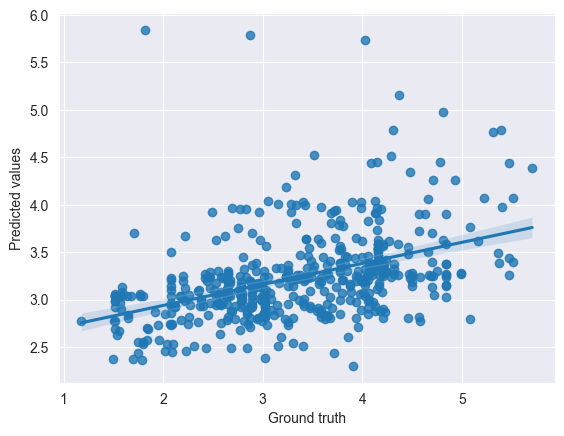

In [17]:
# Vẽ biểu đồ hồi quy
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)
fig.set(xlabel='Ground truth', ylabel='Predicted values')